In [1]:
import pandas as pd
import pandas_profiling as pdp
import matplotlib.pyplot as plt
import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.decomposition import PCA

from xgboost.sklearn import XGBRegressor
from sklearn.utils import all_estimators

import warnings

warnings.filterwarnings("ignore")

In [2]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")
data_test_ids = data_test.pop("Id")

In [3]:
profile = pdp.ProfileReport(data_train)
profile.to_file("profile_start.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]


In [4]:
# Dropping columns with a high percentage of zero or NaN values
to_drop_list = ["Id", "Alley", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "2ndFlrSF", "LowQualFinSF", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea",
"PoolQC", "Fence", "MiscFeature", "MiscVal"]
data_train.drop(to_drop_list, axis=1, inplace=True)
data_test.drop(to_drop_list[1:], axis=1, inplace=True)

In [5]:
# Feature engineering

data_train["TotalLot"] = data_train["LotFrontage"] * data_train["LotArea"]
data_test["TotalLot"] = data_test["LotFrontage"] * data_test["LotArea"]

data_train["TotalQuality"] = data_train["OverallQual"] * data_train["OverallCond"]
data_test["TotalQuality"] = data_test["OverallQual"] * data_test["OverallCond"]

data_train["LastRemodel"] = data_train["YearRemodAdd"] - data_train["YearBuilt"]
data_test["LastRemodel"] = data_test["YearRemodAdd"] - data_test["YearBuilt"]

to_drop_list = ["LotFrontage", "LotArea", "OverallQual", "OverallCond", "YearRemodAdd"] # Drop unneeded features are they are included in the engineered features
data_train.drop(to_drop_list, axis=1, inplace=True)
data_test.drop(to_drop_list, axis=1, inplace=True)

In [6]:
data_train.head(10)

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageCond,PavedDrive,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalLot,TotalQuality,LastRemodel
0,60,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,TA,Y,2,2008,WD,Normal,208500,549250.0,35,0
1,20,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,TA,Y,5,2007,WD,Normal,181500,768000.0,48,0
2,60,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,TA,Y,9,2008,WD,Normal,223500,765000.0,35,1
3,70,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,TA,Y,2,2006,WD,Abnorml,140000,573000.0,35,55
4,60,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,TA,Y,12,2008,WD,Normal,250000,1197840.0,40,0
5,50,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,...,TA,Y,10,2009,WD,Normal,143000,1199775.0,25,2
6,20,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,...,TA,Y,8,2007,WD,Normal,307000,756300.0,40,1
7,60,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,...,TA,Y,11,2009,WD,Normal,200000,NaN,42,0
8,50,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,...,TA,Y,4,2008,WD,Abnorml,129900,312120.0,35,19
9,190,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,...,TA,Y,1,2008,WD,Normal,118000,371000.0,30,11


In [7]:
categorical_cols = data_train.select_dtypes(["object"]).columns.tolist() # Get all columns which are categorical
print(categorical_cols)
# Fill missing values in categorical columns with that column's mode
data_train.fillna(data_train[categorical_cols].mode().iloc[0], inplace=True) 
data_test.fillna(data_test[categorical_cols].mode().iloc[0], inplace=True)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


In [8]:
cols_with_empty_train = data_train.columns[data_train.isna().any()].tolist() # Get all columns with empty values
cols_with_empty_test = data_test.columns[data_test.isna().any()].tolist() # Get all columns with empty values
# Impute missing numerical values
imputer = IterativeImputer(max_iter=20, random_state=42)
data_train[cols_with_empty_train] = imputer.fit_transform(data_train[cols_with_empty_train])
data_test[cols_with_empty_test] = imputer.fit_transform(data_test[cols_with_empty_test])

In [9]:
# Encode categorical columns with ordinal integers (dummy variables)
encoder = OrdinalEncoder()
data_train[categorical_cols] = encoder.fit_transform(data_train[categorical_cols])
data_test[categorical_cols] = encoder.fit_transform(data_test[categorical_cols])

In [10]:
data_train.head()

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageCond,PavedDrive,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalLot,TotalQuality,LastRemodel
0,60,3.0,1.0,3.0,3.0,0.0,4.0,0.0,5.0,2.0,...,4.0,2.0,2,2008,8.0,4.0,208500,549250.0,35,0
1,20,3.0,1.0,3.0,3.0,0.0,2.0,0.0,24.0,1.0,...,4.0,2.0,5,2007,8.0,4.0,181500,768000.0,48,0
2,60,3.0,1.0,0.0,3.0,0.0,4.0,0.0,5.0,2.0,...,4.0,2.0,9,2008,8.0,4.0,223500,765000.0,35,1
3,70,3.0,1.0,0.0,3.0,0.0,0.0,0.0,6.0,2.0,...,4.0,2.0,2,2006,8.0,0.0,140000,573000.0,35,55
4,60,3.0,1.0,0.0,3.0,0.0,2.0,0.0,15.0,2.0,...,4.0,2.0,12,2008,8.0,4.0,250000,1197840.0,40,0


In [11]:
y = data_train.pop("SalePrice") # Remove the labels before scaling

In [12]:
mm_scaler = MinMaxScaler((0, 1))
sta_scaler = StandardScaler()

#  Standardize all columns
data_train[data_train.columns] = sta_scaler.fit_transform(data_train[data_train.columns])
data_test[data_test.columns] = sta_scaler.fit_transform(data_test[data_test.columns])

#  # Scale to range 0-1
# data_train[data_train.columns] = mm_scaler.fit_transform(data_train[data_train.columns])
# data_test[data_test.columns] = mm_scaler.fit_transform(data_test[data_test.columns])

data_train.head()

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageQual,GarageCond,PavedDrive,MoSold,YrSold,SaleType,SaleCondition,TotalLot,TotalQuality,LastRemodel
0,0.073375,-0.045532,0.064238,0.750731,0.314667,-0.02618,0.604670,-0.225716,-1.206215,-0.036289,...,0.215646,0.186019,0.289745,-1.599111,0.138777,0.313867,0.208502,-0.209784,0.123216,-0.555742
1,-0.872563,-0.045532,0.064238,0.750731,0.314667,-0.02618,-0.628316,-0.225716,1.954302,-1.188074,...,0.215646,0.186019,0.289745,-0.489110,-0.614439,0.313867,0.208502,-0.010084,1.533735,-0.555742
2,0.073375,-0.045532,0.064238,-1.378933,0.314667,-0.02618,0.604670,-0.225716,-1.206215,-0.036289,...,0.215646,0.186019,0.289745,0.990891,0.138777,0.313867,0.208502,-0.012823,0.123216,-0.514873
3,0.309859,-0.045532,0.064238,-1.378933,0.314667,-0.02618,-1.861302,-0.225716,-1.039872,-0.036289,...,0.215646,0.186019,0.289745,-1.599111,-1.367655,0.313867,-3.426284,-0.188103,0.123216,1.692084
4,0.073375,-0.045532,0.064238,-1.378933,0.314667,-0.02618,-0.628316,-0.225716,0.457215,-0.036289,...,0.215646,0.186019,0.289745,2.100892,0.138777,0.313867,0.208502,0.382324,0.665723,-0.555742


In [13]:
data_test.head()

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageQual,GarageCond,PavedDrive,MoSold,YrSold,SaleType,SaleCondition,TotalLot,TotalQuality,LastRemodel
0,-0.874711,-1.501777,0.06426,0.742620,0.31870,0.0,0.572445,-0.207992,-0.105672,-1.193183,...,0.250409,0.186902,0.339114,-0.038281,1.713905,0.32475,0.201383,0.380196,-0.394200,-0.520737
1,-0.874711,-0.039098,0.06426,-1.384637,0.31870,0.0,-1.950811,-0.207992,-0.105672,-0.056113,...,0.250409,0.186902,0.339114,-0.038281,1.713905,0.32475,0.201383,0.796869,0.261477,-0.520737
2,0.061351,-0.039098,0.06426,-1.384637,0.31870,0.0,0.572445,-0.207992,-0.784114,-0.056113,...,0.250409,0.186902,0.339114,-1.140614,1.713905,0.32475,0.201383,0.552978,-0.940597,-0.478418
3,0.061351,-0.039098,0.06426,-1.384637,0.31870,0.0,0.572445,-0.207992,-0.784114,-0.056113,...,0.250409,0.186902,0.339114,-0.038281,1.713905,0.32475,0.201383,0.100758,0.261477,-0.520737
4,1.465443,-0.039098,0.06426,-1.384637,-2.53396,0.0,0.572445,-0.207992,1.590431,-0.056113,...,0.250409,0.186902,0.339114,-1.875504,1.713905,0.32475,0.201383,-0.937975,0.698594,-0.520737


In [14]:
pca = PCA(n_components=3)
data_train_pca = pca.fit_transform(data_train)
data_test_pca = pca.fit_transform(data_test)

data_train_processed = data_train.copy()
data_test_processed = data_test.copy()

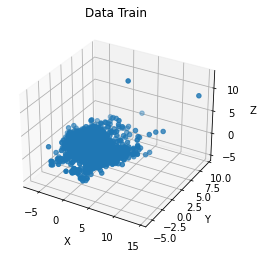

In [15]:
# Plot our data which been scaled and dimensionality reducted to detect possible outliers
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(data_train_pca[:,0], data_train_pca[:,1], data_train_pca[:,2]) 
plt.title("Data Train")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

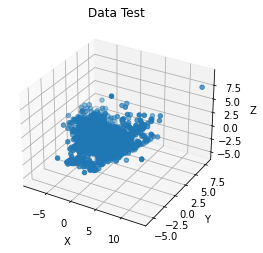

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(data_test_pca[:,0], data_test_pca[:,1], data_test_pca[:,2]) 
plt.title("Data Test")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data_train_processed, y, test_size=0.3)

In [18]:
estimators_all = all_estimators(type_filter="regressor") # Get all regressor estimators from sklearn library
est_tuples = [] # Estimators we're going to test and other information
for name, RegressorClass in estimators_all:
    try:
        #print(name)
        est_tuples.append([name, RegressorClass(), 0])
    except Exception as e:
        pass # Ignore all estimators which need a init parameter
estimators_all.append(("XGBoostRegressor", XGBRegressor))
for est in est_tuples:
    try:
        est[1].fit(X_train, y_train)
        est[2] = est[1].score(X_test, y_test)
    except Exception as e:
        pass

est_tuples = sorted(est_tuples, key=lambda x: x[2], reverse=True)
print(f"""Best Regressor: {est_tuples[0][0]} 
Score: {est_tuples[0][2]}""")

Best Regressor: GradientBoostingRegressor 
Score: 0.9126374097387948


In [23]:
# Tune hyper-parameters for the regressor we chose
param_grid = {
    "learning_rate" : np.arange(0.1, 1, 0.1),
    "n_estimators" : np.arange(100, 1000, 100),
    "subsample" : np.arange(0.1, 2, 0.2)
}
cv = KFold(n_splits=10, shuffle=True, random_state=23)
grid_search = GridSearchCV(est_tuples[0][1], param_grid=param_grid, scoring="r2", n_jobs=-1, cv=cv)
grid_search.fit(data_train_pca, y)
print(grid_search.best_params_)

{'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.7000000000000001}


In [24]:
reg_final = est_tuples[0][1] # Our final regressor
reg_final.set_params(**grid_search.best_params_)
reg_final.fit(data_train_processed, y)

GradientBoostingRegressor(subsample=0.7000000000000001)

In [25]:
prediction = reg_final.predict(data_test_processed)
result = pd.DataFrame({"Id" : data_test_ids, "SalePrice" : prediction})
result.head()

,Id,SalePrice
0,1461,115527.586112
1,1462,150800.286505
2,1463,175285.352348
3,1464,180495.692810
4,1465,203966.684738


In [26]:
result.to_csv("result.csv", index=False)